In [5]:
"""
Packages
"""

using Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using Revise
using LinearAlgebra
using HybridRobotDynamics
using BenchmarkTools
using SiLQR

  Activating project at `~/dev/projects/SiLQR.jl`


In [6]:
"""
2D Double Integrator Model
"""

# System dimensions
nx = 4
nu = 2

# Dynamics ODE
ẋ = (x,u) -> [x[3:4]; u]
mI = HybridMode(ẋ)

# Transitions and modes
transitions = Dict{Symbol, Transition}(Dict())
modes = Dict(:nominal => mI)

# Define the system
system = HybridSystem(nx, nu, transitions, modes)

nothing

In [7]:
"""
Solver Setup
"""

# Bouncing ball with thrust model
#system = bouncing_ball()

# Stage and terminal costs
Q = 1e-4 * diagm([1.0, 1.0, 0.1, 0.1])
R = 1e-6 * I(system.nu)
Qf = 1e2 * Q
stage(x, u) = x'*Q*x + u'*R*u
terminal(x) = x'*Qf*x

# RK4 integrator
rk4 = ExplicitIntegrator(:rk4)

# Problem parameters
N = 50
Δt = 0.1
params = SiLQR.ProblemParameters(system, stage, terminal, rk4, N, Δt)

# Reference trajectory and initial conditions
xref = [10.0; 10.0; 0.0; 0.0]
uref = zeros(system.nu)
params.xrefs = [xref for k = 1:N]
params.urefs = [uref for k = 1:(N-1)]
params.x0 = [0.0, 0.0, 0.0, 0.0]
params.mI = :nominal

# Pre-allocate solver memory
terms = SiLQR.ProblemTerms(params)

nothing

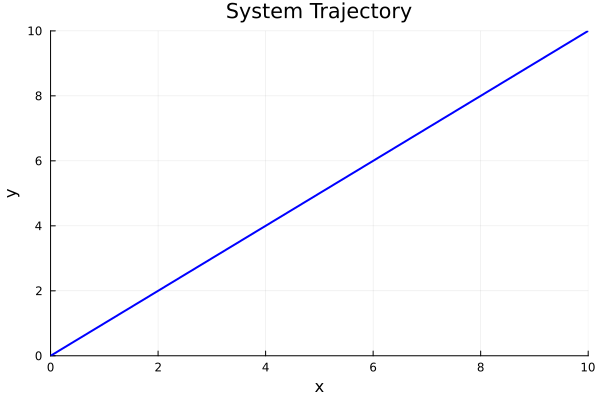

iter      J           ΔJ        |f̂|        α         
-----------------------------------------------
  1    1.205e-01   5.71e-08   0.00e+00  1.0000    
Optimal solution found!
  0.000957 seconds (9.30 k allocations: 1.035 MiB)


In [14]:
"""
Solve using SiLQR
"""

@time SiLQR.SiLQR_solve!(terms, params; verbose=true)
xs = reduce(vcat, terms.fwd.xs)
plot_2d_states(N, system.nx, (1,2), xs)
nothing